# Fine-tuning for Video Classification with 🤗 Transformers
- Ref: 
    - https://github.com/huggingface/notebooks/blob/main/examples/video_classification.ipynb




## Configure device

In [1]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
    if torch.mps.driver_allocated_memory() - torch.mps.current_allocated_memory()< 1e4:
        print("Not enough mps memory, convert to cpu mode")
        t_device = torch.device("cpu")
        s_device = "cpu"
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(t_device)

cuda


## Model

In [2]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

## Fine-tuning a model on a video classification task

### Loading the dataset

In [3]:
# from huggingface_hub import notebook_login

# notebook_login()

In [4]:
from huggingface_hub import hf_hub_download


hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset", cache_dir="./temp/data/"
)

In [5]:
file_path

'./temp/data/datasets--sayakpaul--ucf101-subset/snapshots/b9984b8d2a95e4a1879e1b071e9433858d0bc24a/UCF101_subset.tar.gz'

In [6]:
# !tar xf {file_path} -C ./temp/data
# !tar xf {file_path} 

In [7]:
dataset_root_path = "./temp/data/UCF101_subset"

!find {dataset_root_path} | head -7

./temp/data/UCF101_subset
./temp/data/UCF101_subset/test
./temp/data/UCF101_subset/test/Basketball
./temp/data/UCF101_subset/test/Basketball/v_Basketball_g18_c04.avi
./temp/data/UCF101_subset/test/Basketball/v_Basketball_g18_c02.avi
./temp/data/UCF101_subset/test/Basketball/v_Basketball_g05_c02.avi
./temp/data/UCF101_subset/test/Basketball/v_Basketball_g02_c06.avi
find: ‘standard output’: Broken pipe
find: write error


In [8]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405


In [9]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('temp/data/UCF101_subset/train/Basketball/v_Basketball_g04_c02.avi'),
 PosixPath('temp/data/UCF101_subset/train/Basketball/v_Basketball_g01_c03.avi'),
 PosixPath('temp/data/UCF101_subset/train/Basketball/v_Basketball_g03_c06.avi'),
 PosixPath('temp/data/UCF101_subset/train/Basketball/v_Basketball_g17_c04.avi'),
 PosixPath('temp/data/UCF101_subset/train/Basketball/v_Basketball_g15_c07.avi')]

In [10]:
class_labels = sorted({str(path).split("/")[4] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


### Loading Model

In [11]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Constructing the datasets for training

In [12]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [13]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [14]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

In [15]:
sample_video = next(iter(train_dataset))
sample_video.keys()



dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [16]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


In [17]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="./temp/sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

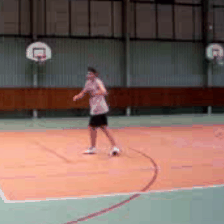

In [18]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [19]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_BasketballDunk_g12_c01.avi
video_index 60
clip_index 0
aug_index 0
label 8
Video label: BasketballDunk


In [20]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.
    
    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

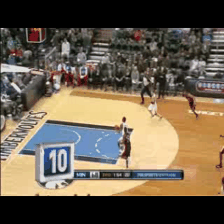

In [21]:
display_gif(sample_test_video["video"])

In [22]:
before_logits = run_inference(model, sample_test_video["video"])
before_predicted_class_idx = before_logits.argmax(-1).item()
print("Before Predicted class:", model.config.id2label[before_predicted_class_idx])

Before Predicted class: BenchPress


### Training the model

In [23]:
from transformers import TrainingArguments, Trainer
import os

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4
output_dir = os.path.join("./temp", new_model_name) 

args = TrainingArguments(
    # new_model_name,
    output_dir,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    # per_device_train_batch_size=batch_size,
    # per_device_eval_batch_size=batch_size,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [24]:
import evaluate

metric = evaluate.load("accuracy")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [25]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [26]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/tmp/ipykernel_761869/3087471478.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[2025-07-23 16:22:43,934] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/hyunjae/anaconda3/envs/dl_drill_pthf/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~r

[2025-07-23 16:22:45,266] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [27]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,1.825800,1.385450,0.600000
1,0.622500,0.755012,0.757143


In [28]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.7884629964828491,
 'eval_accuracy': 0.8,
 'eval_runtime': 14.0435,
 'eval_samples_per_second': 11.037,
 'eval_steps_per_second': 2.777,
 'epoch': 1.4932432432432432}

In [29]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =     1.4932
  eval_accuracy           =        0.8
  eval_loss               =     0.7885
  eval_runtime            = 0:00:13.68
  eval_samples_per_second =     11.322
  eval_steps_per_second   =      2.849


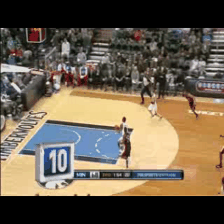

In [30]:
display_gif(sample_test_video["video"])

In [ ]:
after_logits = run_inference(model, sample_test_video["video"])
after_predicted_class_idx = after_logits.argmax(-1).item()
print("Before Fine Tuning :: Predicted class :", model.config.id2label[before_predicted_class_idx])
print("After Fine Tuning  :: Predicted class :", model.config.id2label[after_predicted_class_idx])

Before Fine Tuning :: Predicted class : BenchPress
After Fine Tuning  :: Predicted class : BasketballDunk


: 